# Manifold learning with Feature-type distributed clustering workflow is more informative compared to UMAP for tabular clinical datasets

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import math
import umap.umap_ as umap
%config InlineBackend.figure_format = 'svg'

In [2]:
from cluster_val import *

## Importing data

In [3]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
data_with_target=pd.read_csv('survey lung cancer.csv')

## Data pre-processing

In [4]:
data_with_target.isna().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

In [5]:
gender_mod= {'GENDER': {'F':1,'M':0}}
data_with_target.replace(gender_mod,inplace=True)
data_with_target['GENDER']

0      0
1      0
2      1
3      0
4      1
      ..
304    1
305    0
306    0
307    0
308    0
Name: GENDER, Length: 309, dtype: int64

In [6]:
np.random.seed(42)
data_with_target=data_with_target.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(309)]

data_with_target.set_index(pd.Series(i), inplace=True)

In [7]:
data_with_target['LUNG_CANCER']

0      YES
1      YES
2      YES
3      YES
4      YES
      ... 
304    YES
305    YES
306    YES
307     NO
308    YES
Name: LUNG_CANCER, Length: 309, dtype: object

In [8]:
data=data_with_target.drop(['LUNG_CANCER'],axis=1)

In [9]:
data.shape

(309, 15)

## UMAP on original data

In [10]:
from fdc.fdc import feature_clustering

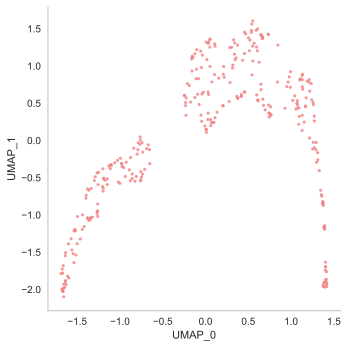

In [11]:
umap_emb=feature_clustering(15,0.1,'euclidean',data,True)

## Silhouette_score  and Dunn index for umap clusters extracted using K-means clustering

In [12]:
from fdc.clustering import Clustering

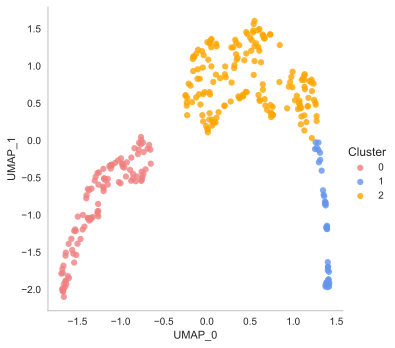

In [13]:
umap_clustering=Clustering(umap_emb,umap_emb,True)
umap_cluster_list,umap_cluster_counts=umap_clustering.K_means(3)

In [14]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [15]:
 silhouette_score(umap_emb, umap_cluster_list, metric='euclidean')


0.6862806500192853

## Visualizing Silhouette score (you can also choose the number of clusters based on score)

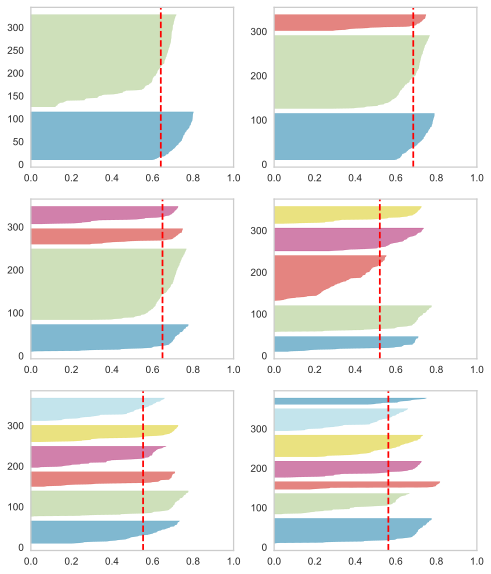

In [16]:
Silhouette_visual(umap_emb)

## Elbow plot for umap_embedding

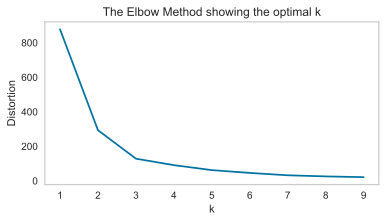

In [17]:
elbow_plot(umap_emb)

In [18]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list))

0.03111612929822423

## Silhouette_score  and Dunn index for umap clusters extracted using Agglomerative clustering

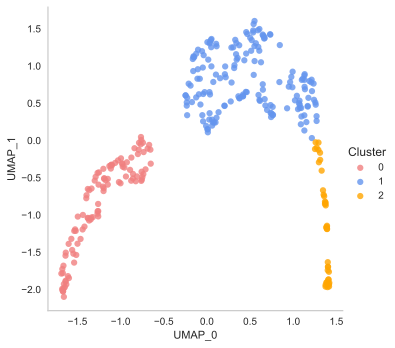

In [19]:
umap_cluster_list_agglo,umap_cluster_counts_agglo=umap_clustering.Agglomerative(3,'euclidean','ward')

In [20]:
silhouette_score(umap_emb, umap_cluster_list_agglo, metric='euclidean')

0.6640499989907629

In [21]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list_agglo))

0.03111612929822423

## Silhouette_score  and Dunn index for umap clusters extracted using DBSCAN clustering

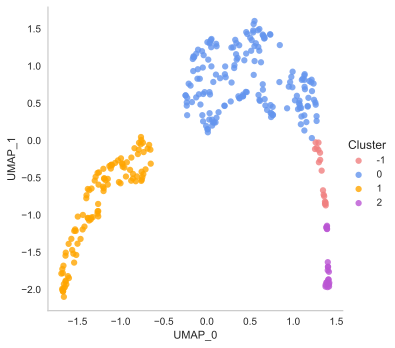

In [22]:
umap_cluster_list_dbscan,umap_cluster_counts_dbscan=umap_clustering.DBSCAN(0.5,20)

In [23]:
#removing noise indices from the embeddings
non_noise_indices= np.where(np.array(umap_cluster_list_dbscan)!=-1)
umap_emb= umap_emb.iloc[non_noise_indices]
#FDC_emb_low= FDC_emb_low.iloc[non_noise_indices]
umap_cluster_list_dbscan= np.array(umap_cluster_list_dbscan)[non_noise_indices]


In [24]:
silhouette_score(umap_emb, umap_cluster_list_dbscan, metric='euclidean')

0.7044672356590044

In [25]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list_dbscan))

0.25553479433352333

## Dividing features
- cont_list=continueous features
- ord_list=ordinal features
- nom_list=nominal features



In [26]:
cont_list=['AGE']

ord_list=['SMOKING','GENDER','CHRONIC DISEASE','ALCOHOL CONSUMING','SHORTNESS OF BREATH']

nom_list=['YELLOW_FINGERS','ANXIETY','PEER_PRESSURE','WHEEZING','COUGHING','SWALLOWING DIFFICULTY','CHEST PAIN','FATIGUE ','ALLERGY ']

In [27]:
len(ord_list)

5

In [28]:
len(nom_list)

9

In [29]:
len(cont_list)

1

## FDC on original data

In [30]:
from fdc.fdc import FDC, Clustering
from fdc.fdc import canberra_modified
modified_can = canberra_modified

FDC.normalize (init): 0.00000 / 0.000s
FDC.normalize (clustering CONT): 4.15625 / 4.156s
FDC.normalize (clustering ORD): 5.60938 / 9.766s
FDC.normalize (clustering NOM): 4.82812 / 14.594s
FDC.normalize (concat): 0.00000 / 14.594s
FDC.normalize (umap 5 -> 2): 3.03125 / 17.625s
FDC.normalize (array -> DataFrame): 0.00000 / 17.625s


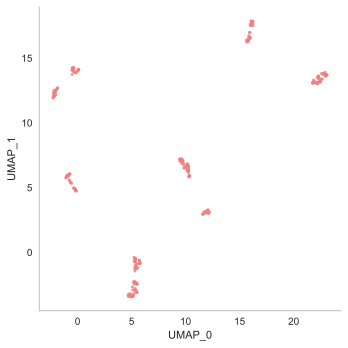

FDC.normalize (plotting): 1.56250 / 19.188s
FDC.normalize (array -> DataFrame): 0.00000 / 19.188s
FDC.normalize (total): 0.00000 / 19.188s


In [31]:

fdc = FDC(clustering_cont=Clustering('euclidean',15,0.1,max_components=1)
          , clustering_ord=Clustering('canberra',15,0.1)
          , clustering_nom=Clustering('hamming',15,0.1)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, nomial=nom_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,n_neighbors=30, min_dist=0.001,cont_list=cont_list, nom_list=nom_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

## Silhouette_score  and Dunn index for fdc clusters extracted (intermediate_dim) using K-means clustering

In [32]:
from fdc.clustering import Clustering

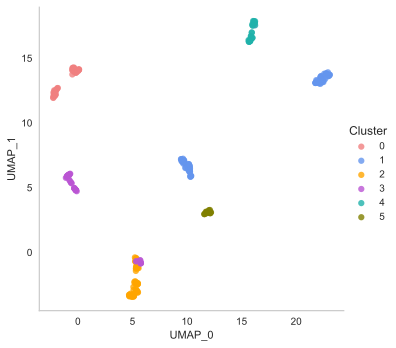

In [33]:
clustering=Clustering(FDC_emb_high,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(6)

In [34]:
FDC_emb_high['Cluster'] = cluster_list

In [35]:
silhouette_score(FDC_emb_high, cluster_list, metric='euclidean')


0.5473673986775849

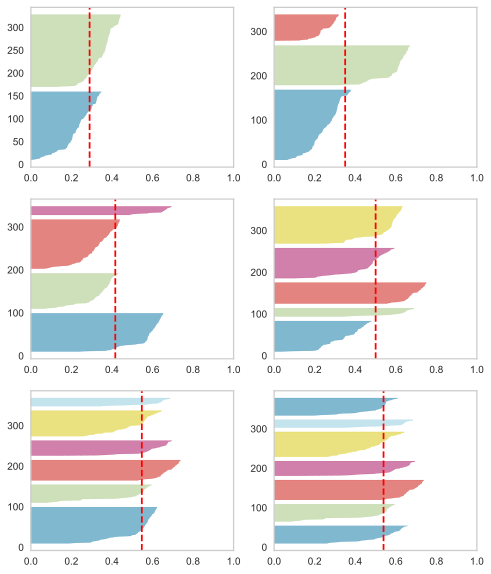

In [36]:
Silhouette_visual(FDC_emb_high)

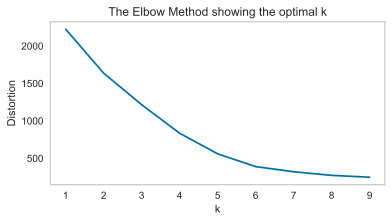

In [37]:
elbow_plot(FDC_emb_high)

In [38]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list))

0.08665263226928745

## Silhouette_score  and Dunn index for fdc clusters extracted (intermediate_dim) using Agglomerative clustering

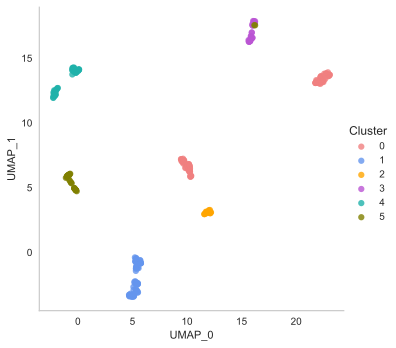

In [39]:
cluster_list_agglo,cluster_counts_agglo=clustering.Agglomerative(6,'euclidean','ward')

In [40]:
FDC_emb_high['Cluster'] = cluster_list_agglo

In [41]:
silhouette_score(FDC_emb_high, cluster_list_agglo, metric='euclidean')

0.5255713632427612

In [42]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list_agglo))

0.13127763663166897

## Silhouette_score  and Dunn index for fdc clusters extracted (intermediate_dim) using DBSCAN clustering

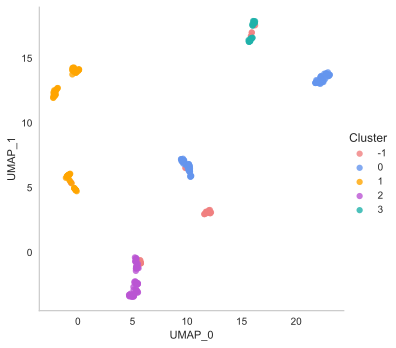

In [43]:
cluster_list_dbscan,cluster_counts_dbscan=clustering.DBSCAN(1.2,20)

In [44]:
cluster_counts_dbscan

array([38, 88, 84, 66, 33], dtype=int64)

In [45]:
FDC_emb_high['Cluster'] = cluster_list_dbscan

In [46]:
#removing noise indices from the embeddings
non_noise_indices= np.where(np.array(cluster_list_dbscan)!=-1)
FDC_emb_high= FDC_emb_high.iloc[non_noise_indices]
FDC_emb_low= FDC_emb_low.iloc[non_noise_indices]
cluster_list_dbscan= np.array(cluster_list_dbscan)[non_noise_indices]


In [47]:
silhouette_score(FDC_emb_high, cluster_list_dbscan, metric='euclidean')

0.5400059882088042

In [48]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list_dbscan))

0.27988826254302485